# Import modules and read data

In [1]:
import numpy as np
import pandas as pd
import scipy.linalg
from superlink.hydraulics import SuperLink
from superlink.simulation import Simulation
from superlink.nutils import interpolate_sample

In [2]:
# Specify data path
model_input_path = '../data/adaptive_step'
data_input_path = '../data/six_pipes'

# Get model components
superjunctions = pd.read_csv(f'{model_input_path}/superjunctions.csv')
superlinks = pd.read_csv(f'{model_input_path}/superlinks.csv')

# Read input data
Q_in = pd.read_csv(f'{data_input_path}/flow_input.csv', index_col=0)
H_bc = pd.read_csv(f'{data_input_path}/boundary_stage.csv', index_col=0)

In [3]:
Q_in = Q_in.reindex(np.arange(0, Q_in.index[-1], 30)).interpolate()
H_bc = H_bc.reindex(np.arange(0, H_bc.index[-1], 30)).interpolate()

In [4]:
np.random.seed(0)

process_std_dev = 0.05
measurement_std_dev = 0.01
Q_in_noisy = Q_in + process_std_dev*np.random.randn(*Q_in.shape)

# Create and run clean model

In [5]:
superlink = SuperLink(superlinks, superjunctions, min_depth=0.0, 
                      njunctions_fixed=4, auto_permute=True)    

In [6]:
# Set initial timestep
dt = 30
# Create lists to store error and timestep
errs = []
dts = []

# Create simulation context manager
with Simulation(superlink, Q_in=Q_in, H_bc=H_bc) as clean_simulation:
    # While simulation time has not expired...
    for step in clean_simulation.steps:
        if clean_simulation.t >= clean_simulation.t_end:
            break
        # Step model forward in time
        clean_simulation.step(dt=dt)
        # Record internal depth and flow states
        clean_simulation.record_state()
        # Print progress bar
        clean_simulation.print_progress()

[=================================================-] 98.1%

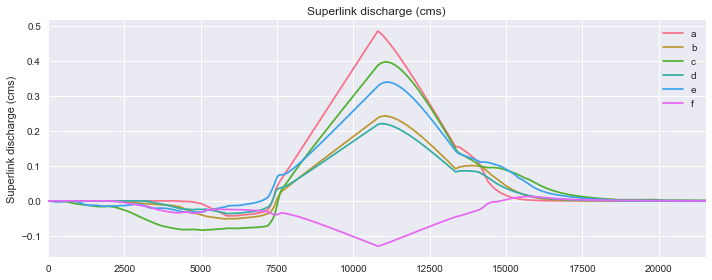

In [7]:
# Plot results
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('husl')
%matplotlib inline

# Instantiate plot
fig, ax = plt.subplots(1, figsize=(10, 4))

# Compute average discharge in superlinks
clean_simulation.states.Q_k = (clean_simulation.states._Q_uk
                               + clean_simulation.states._Q_dk) / 2

# Plot results
clean_simulation.states.Q_k.plot(ax=ax, title='Superlink discharge (cms)')

# Configure plots
ax.set_ylabel('Superlink discharge (cms)')
plt.tight_layout()

# Create and run noisy model

In [8]:
superlink = SuperLink(superlinks, superjunctions, min_depth=0.0, 
                      njunctions_fixed=4, auto_permute=True)    

In [9]:
# Set initial timestep
dt = 30
# Create lists to store error and timestep
errs = []
dts = []

# Create simulation context manager
with Simulation(superlink, Q_in=Q_in_noisy, H_bc=H_bc) as noisy_simulation:
    # While simulation time has not expired...
    for step in noisy_simulation.steps:
        if noisy_simulation.t >= noisy_simulation.t_end:
            break
        # Step model forward in time
        noisy_simulation.step(dt=dt)
        # Record internal depth and flow states
        noisy_simulation.record_state()
        # Print progress bar
        noisy_simulation.print_progress()

[=================================================-] 98.1%

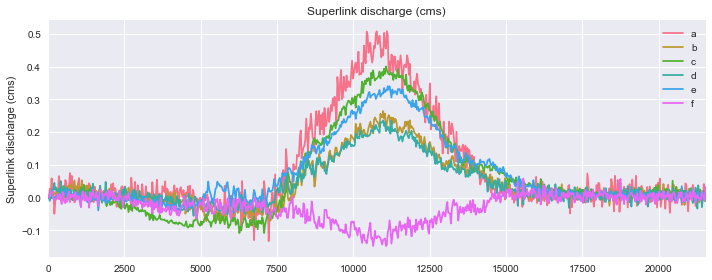

In [10]:
# Plot results
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('husl')
%matplotlib inline

# Instantiate plot
fig, ax = plt.subplots(1, figsize=(10, 4))

# Compute average discharge in superlinks
noisy_simulation.states.Q_k = (noisy_simulation.states._Q_uk + noisy_simulation.states._Q_dk) / 2

# Plot results
noisy_simulation.states.Q_k.plot(ax=ax, title='Superlink discharge (cms)')

# Configure plots
ax.set_ylabel('Superlink discharge (cms)')
plt.tight_layout()

# Create and run filtered model

In [11]:
superlink = SuperLink(superlinks, superjunctions, min_depth=0.0, 
                      njunctions_fixed=4, auto_permute=True)    

In [12]:
M = superlink.M
H = np.eye(M)
Qcov = (process_std_dev**2)*np.eye(M)
Rcov = (measurement_std_dev**2)*np.eye(M)
C = np.eye(M)
P = C @ Qcov @ C.T
I = np.eye(M)
bc = superlink.bc.astype(bool)

P_x_k_k = P

In [13]:
Z = (clean_simulation.states.H_j).copy(deep=True)
Z += (measurement_std_dev * np.random.randn(*Z.shape))

In [14]:
# Set initial timestep
dt = 30
# Create lists to store error and timestep
errs = []
dts = []

# Create simulation context manager
with Simulation(superlink, Q_in=Q_in_noisy, H_bc=H_bc) as filtered_simulation:
    # While simulation time has not expired...
    for step in filtered_simulation.steps:
        if filtered_simulation.t >= filtered_simulation.t_end:
            break
        # Step model forward in time
        filtered_simulation.step(dt=dt)
        
        Z_next = interpolate_sample(filtered_simulation.t,
                                    Z.index.values,
                                    Z.values)
        b = filtered_simulation.model.b
        A_1 = filtered_simulation.model.A + filtered_simulation.model.W
        A_2 = np.diag(np.where(~bc, filtered_simulation.model._A_sj / dt, 0))
        y_k1_k = b
        A_1_inv = scipy.linalg.inv(A_1)
        H_1 = H @ A_1_inv
        P_y_k1_k = A_2 @ P_x_k_k @ A_2.T + C @ Qcov @ C.T
        L_y_k1 = P_y_k1_k @ H_1.T @ scipy.linalg.inv((H_1 @ P_y_k1_k @ H_1.T) + Rcov)
        P_y_k1_k1 = (I - L_y_k1 @ H_1) @ P_y_k1_k
        b_hat = y_k1_k + L_y_k1 @ (Z_next - H_1 @ y_k1_k)
        P_x_k1_k1 = A_1_inv @ P_y_k1_k1 @ A_1_inv.T
        P_x_k_k = P_x_k1_k1
        
        filtered_simulation.model.b = b_hat
        filtered_simulation.model.solve_banded_matrix()
        filtered_simulation.model.solve_superlink_flows()
        filtered_simulation.model.solve_superlink_depths()
        filtered_simulation.model.solve_internals_backwards()
        
        # Record internal depth and flow states
        filtered_simulation.record_state()
        # Print progress bar
        filtered_simulation.print_progress()

[=================================================-] 98.1%

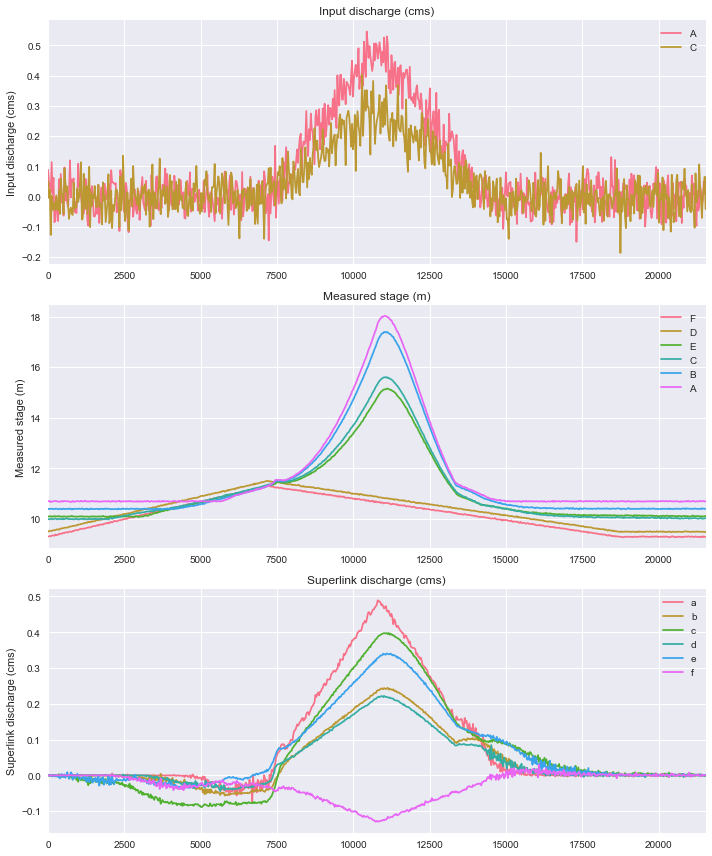

In [15]:
# Plot results
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('husl')
%matplotlib inline

# Instantiate plot
fig, ax = plt.subplots(3, figsize=(10, 12))

# Compute average discharge in superlinks
filtered_simulation.states.Q_k = (filtered_simulation.states._Q_uk
                                  + filtered_simulation.states._Q_dk) / 2

# Plot results
filtered_simulation.Q_in[['A', 'C']].plot(ax=ax[0], title='Input discharge (cms)')
Z.plot(ax=ax[1], title='Measured stage (m)')
filtered_simulation.states.Q_k.plot(ax=ax[2], title='Superlink discharge (cms)')

# Configure plots
ax[0].set_ylabel('Input discharge (cms)')
ax[1].set_ylabel('Measured stage (m)')
ax[2].set_ylabel('Superlink discharge (cms)')
plt.tight_layout()